In [30]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, Optim

In [22]:
# Observed data
vars = matread("/Users/eroesch/Dropbox/PhD/year_1/140728_data.mat")
x = mean.(vars[ "NGF5_ppERK"])[1,:]
y = mean.(vars[ "NGF5_ppMEK"])[1,:]
ode_data = transpose(hcat(x,y))
u0 = [x[1],y[1],1.]
tspan = (0.0f0, 1.5f0)
t = range(tspan[1], tspan[2], length = length(x))
species1 = "NGF5_ppERK"
species2 = "NGF5_ppERK";

In [23]:
# Structure to observe training
mutable struct saver
    losses::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,times,count_epochs)
end
function update_saver(saver, loss_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

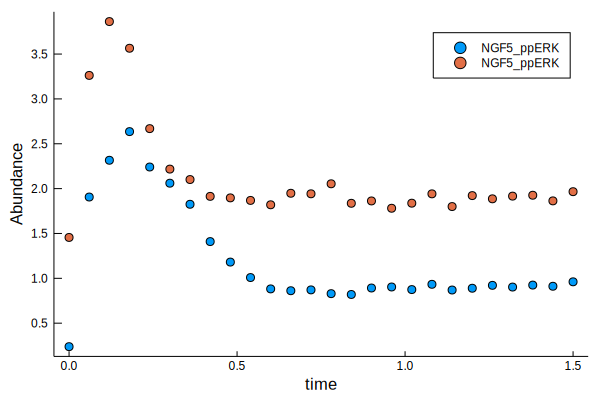

In [24]:
scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1)
scatter!(t, ode_data[2,:], label = species2)

In [25]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(3,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,3))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff = false), saveat = t, reltol = 1e-7, abstol = 1e-9)
n_epochs = 100
sa_l2 = saver(n_epochs)
# L2 loss
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
# Callback function to observe L2 training.
cb = function ()
    sa_l2.count_epochs = sa_l2.count_epochs + 1
    update_saver(sa_l2, Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
end
data1 = Iterators.repeated((), n_epochs)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0)[1:2,:])
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    update_saver(sa, Tracker.data(L2_loss_fct()),0,Dates.Time(Dates.now()))    
end

#17 (generic function with 1 method)

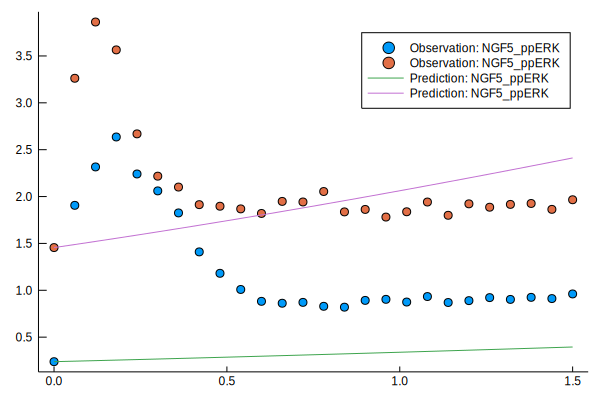

In [26]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [32]:
opt1 = GradientDescent()
# train n_ode with collocation method
@time Flux.train!(L2_loss_fct, ps, data1, opt1, cb = cb1)

MethodError: MethodError: Cannot `convert` an object of type DataStructures.BinaryHeap{Float64,DataStructures.GreaterThan} to an object of type DataStructures.BinaryHeap{Float32,DataStructures.GreaterThan}
Closest candidates are:
  convert(::Type{S}, !Matched::T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)) where {S, T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)} at /Users/eroesch/.julia/packages/CategoricalArrays/xjesC/src/value.jl:91
  convert(::Type{T}, !Matched::T) where T at essentials.jl:154

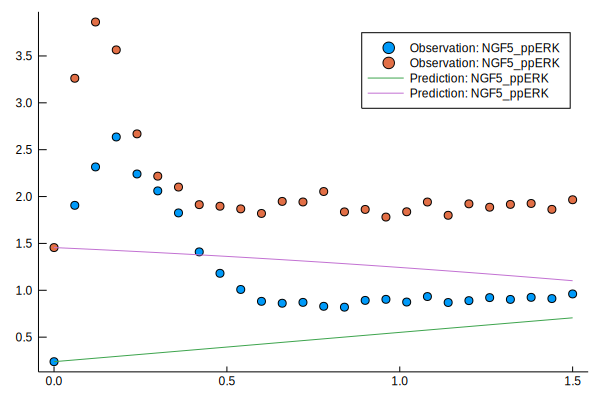

In [9]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

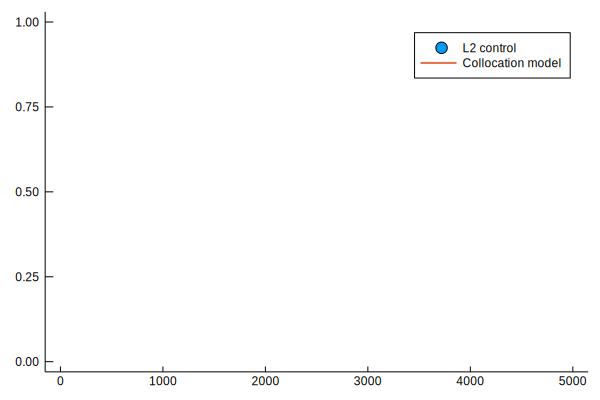

In [10]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s